# Accessing the [oceanwatch](http://oceanwatch.pifsc.noaa.gov/) data with Python

In a [Jupyter](http://jupyter.org/) notebook this first line indicates that the figures will be created 'inline'

In [1]:
%matplotlib inline

Below are the libraries we need, we suggest using the [Anaconda Scientific Python Distribution](https://www.anaconda.com/downloads), which is available for 
all platforms and provides all common Python scientific libraries. 

The [xarray](http://xarray.pydata.org/en/stable/) package can be installed in Anaconda using the `conda` command: 

```
conda install xarray
```

In [2]:
import os
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import requests

### run the following to download the data using the generated URL (you need to copy it from your browser):

In [3]:
url = 'http://oceanwatch.pifsc.noaa.gov/erddap/griddap/OceanWatch_aqua_chla_monthly.nc?chla[(2015-05-01T00:00:00Z):1:(2016-05-01T00:00:00Z)][(17):1:(30)][(195):1:(210)]'

In [4]:
if not os.path.exists('./chl.nc'):
    r = requests.get(url)
    with open('./chl.nc', 'wb') as f:
        f.write(r.content)

### open file with xarray

In [5]:
dset= xr.open_dataset('./chl.nc')

In [6]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 261, longitude: 301, time: 13)
Coordinates:
  * time       (time) datetime64[ns] 2015-05-01 2015-06-01 2015-07-01 ...
  * latitude   (latitude) float64 17.0 17.05 17.1 17.15 17.2 17.25 17.3 ...
  * longitude  (longitude) float64 195.0 195.1 195.1 195.2 195.2 195.2 195.3 ...
Data variables:
    chla       (time, latitude, longitude) float64 0.05137 0.05258 0.0549 ...
Attributes:
    acknowledgements:           NASA Goddard Space Flight Center
    cdm_data_type:              Grid
    comment:                    AQUA MODIS Ocean Color data product
    contributor_name:           NOAA OceanWatch - Central Pacific
    contributor_url:            http://oceanwatch.pifsc.noaa.gov
    Conventions:                COARDS, CF-1.6, ACDD-1.3
    creator_email:              NESDIS.Data.Access@noaa.gov
    creator_name:               NOAA/NESDIS/OceanWatch - Central Pacific
    creator_url:                http://www.nesdis.noaa.gov/
    date_created:        

### examine which variables are included in the dataset


In [7]:
dset.var()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    chla     float64 0.0005661

### extract chla 

In [8]:
chl = dset['chla']

### examine structure of chl

In [9]:
chl.dims

('time', 'latitude', 'longitude')

### examine the dates

In [10]:
chl.time

<xarray.DataArray 'time' (time: 13)>
array(['2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-05-01 2015-06-01 2015-07-01 ...
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [  1.43043840e+09   1.46206080e+09]
    axis:                 T
    ioos_category:        Time
    long_name:            Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00

### get lon and lat

In [11]:
lon = chl['longitude']

In [12]:
lat = chl['latitude']

In [13]:
lon

<xarray.DataArray 'longitude' (longitude: 301)>
array([ 195.  ,  195.05,  195.1 , ...,  209.9 ,  209.95,  210.  ])
Coordinates:
  * longitude  (longitude) float64 195.0 195.1 195.1 195.2 195.2 195.2 195.3 ...
Attributes:
    _CoordinateAxisType:  Lon
    actual_range:         [ 195.  210.]
    axis:                 X
    coordsys:             geographic
    ioos_category:        Location
    long_name:            Longitude
    point_spacing:        even
    standard_name:        longitude
    units:                degrees_east

In [14]:
lat

<xarray.DataArray 'latitude' (latitude: 261)>
array([ 17.  ,  17.05,  17.1 , ...,  29.9 ,  29.95,  30.  ])
Coordinates:
  * latitude  (latitude) float64 17.0 17.05 17.1 17.15 17.2 17.25 17.3 17.35 ...
Attributes:
    _CoordinateAxisType:  Lat
    actual_range:         [ 17.  30.]
    axis:                 Y
    coordsys:             geographic
    ioos_category:        Location
    long_name:            Latitude
    point_spacing:        even
    standard_name:        latitude
    units:                degrees_north

## Working with the data

### Creating a map of Chl a for May 2015 (our first time step)


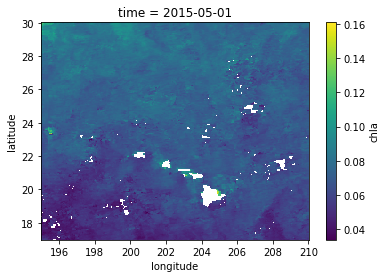

In [15]:
chl.sel(time='2015-05-01').plot()

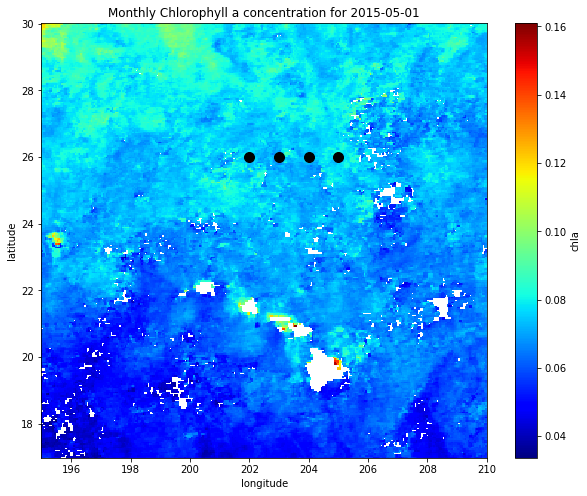

In [16]:
f, ax = plt.subplots(figsize=(10,8))
chl.isel(time=0).plot(cmap=plt.cm.jet, ax=ax)
ax.plot(range(202,205+1),np.repeat(26,4),'ko', markersize=10)
ax.set_title('Monthly Chlorophyll a concentration for {:%Y-%m-%d}'.format(chl.time.to_index()[0]))

## Plotting a time-series of median Chlorophyll a concentration in a box

Let's pick the following box : 24-26N, 200-206E

In [17]:
box = chl.sel(longitude=slice(200, 206), latitude=slice(24,26)).mean('latitude').mean('longitude')

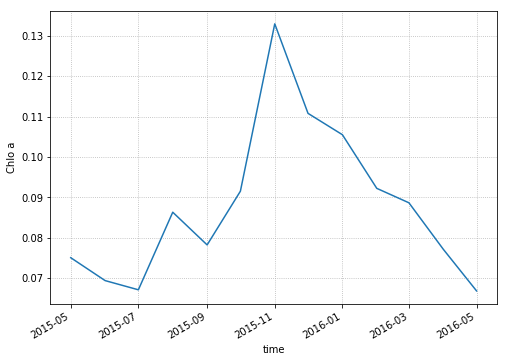

In [18]:
f, ax = plt.subplots(figsize=(8,6))
box.plot(ax=ax)
ax.set_ylabel('Chlo a')
ax.grid(ls=':')

## Creating a map of median Chl a concentration over a year

In [19]:
median_chla = chl.median('time')

### Mapping using [cartopy](https://github.com/SciTools/cartopy) 

In [20]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy import feature as cfeature

In [21]:
proj = ccrs.PlateCarree()

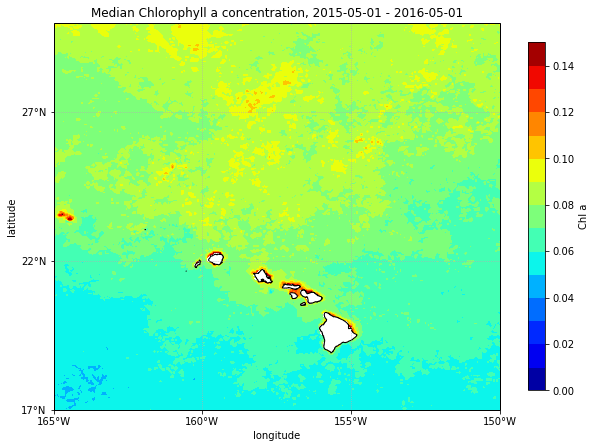

In [24]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})

ax.add_feature(cfeature.GSHHSFeature(scale='full', lw=0.5, facecolor='w'))

im = ax.contourf(lon, lat, median_chla, levels = np.arange(0,0.16,0.01), cmap=plt.cm.jet)

cb = plt.colorbar(im, ax=ax, shrink=0.8)

cb.set_label('Chl a')

xticks = np.arange(lon[0], lon[-1] + 5, 5) - 360. 
yticks = np.arange(lat[0], lat[-1] + 5, 5)

gl = ax.gridlines(draw_labels=False, lw=0.5, linestyle=':', xlocs=xticks, ylocs=yticks)

ax.set_xticks(xticks, crs=proj)

ax.set_yticks(yticks, crs=proj)

lon_formatter = LongitudeFormatter(zero_direction_label=True)

lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlabel('longitude')

ax.set_ylabel('latitude')

ax.set_title('Median Chlorophyll a concentration, {:%Y-%m-%d} - {:%Y-%m-%d}'.\
             format(dset.time.to_index()[0], dset.time.to_index()[-1]))

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])